In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from torchvision.models import *
import yaml
import pandas as pd
import datetime


from sklearn.metrics import roc_auc_score

In [3]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
    path = cfg['path']

In [4]:
chestxrays_root = Path(path)
data_path = chestxrays_root/'data'

In [5]:
full_train_df = pd.read_csv(data_path/'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(data_path/'CheXpert-v1.0-small/valid.csv')

In [6]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Uncertainty strategy
- Atelectasis U-Ones
- Cardiomegaly U-Zeros
- Consolidation U-Zeros
- Edema U-Ones
- Pleural Effusion U-Zeros

In [7]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

### Add target features string

In [8]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [9]:
full_train_df['feature_string'] = full_train_df.apply(feature_string,axis = 1).fillna('')
full_valid_df['feature_string'] = full_valid_df.apply(feature_string,axis = 1).fillna('')

##### Create patient column

In [10]:
valid_perc=0.1

In [11]:
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]

full_train_df['study'] = full_train_df.Path.str.split('/',4,True)[3]
full_valid_df['study'] = full_valid_df.Path.str.split('/',4,True)[3]

In [12]:
patients = full_train_df.patient.unique()

In [13]:
valid_patients = [patient for patient in patients if np.random.rand() < valid_perc]

In [14]:
len(valid_patients)/len(patients)

0.1

In [15]:
full_train_df['train_valid'] = full_train_df.patient.apply(lambda x: x in valid_patients)

In [16]:
full_train_df['train_valid'].value_counts()

False    201192
True      22222
Name: train_valid, dtype: int64

### Set up data set using Fastai datablock

In [17]:
bs=32

test = ImageList.from_df(full_valid_df, data_path, 'Path')

src = (ImageList
        .from_df(full_train_df, data_path, 'Path')
        .split_from_df('train_valid')
        .label_from_df('feature_string',label_delim=';')
        .add_test(test)
       )

In [18]:
def get_data(size):
    return (src.transform(get_transforms(do_flip=False), size=size, padding_mode='zeros')
        .databunch(bs=bs).normalize(imagenet_stats))

## Create a function to evaluate performance of all features

In [19]:
def validation_eval(learn):
    test_preds=learn.get_preds(ds_type=DatasetType.Test)


    preds = test_preds[0]
    acts = full_valid_df[data.classes].values

    auc_scores = {data.classes[i]: roc_auc_score(acts[:,i],preds[:,i]) for i in range(len(chexpert_targets))}

    #average results reported in the associated paper
    chexpert_auc_scores = {'Atelectasis':      0.858,
                           'Cardiomegaly':     0.854,
                           'Consolidation':    0.939,
                           'Edema':            0.941,
                           'Pleural Effusion': 0.936}
    
    max_feat_len = max(map(len, chexpert_targets))
                                                                                      
    avg_chexpert_auc = sum(list(chexpert_auc_scores.values()))/len(chexpert_auc_scores.values())
    avg_auc          = sum(list(auc_scores.values()))/len(auc_scores.values())
                                                                                      
    [print(f'{k: <{max_feat_len}}\t auc: {auc_scores[k]:.3}\t chexpert auc: {chexpert_auc_scores[k]:.3}\t difference:\
    {chexpert_auc_scores[k]-auc_scores[k]:.3}') for k in chexpert_targets]
    
    print(f'\nAverage auc: {avg_auc:.3} \t CheXpert average auc {avg_chexpert_auc:.3}\t Difference {avg_chexpert_auc-avg_auc:.3}')

In [20]:
class CheXpertEvalCallback(LearnerCallback):
    def __init__(self, learn):
        super().__init__(learn)
        self.skip = False
    def on_epoch_begin(self,**kwargs):
        if self.learn.data.valid_dl is None: self.skip = True
    def on_epoch_end(self,**kwargs):
        if self.skip: pass
        validation_eval(self.learn)
        
class SaveCallback(LearnerCallback):
    def __init__(self, learn):
        super().__init__(learn)
        self.epoch = 0
        self.skip = False
    def on_epoch_begin(self,**kwargs):
        if self.learn.data.valid_dl is None: self.skip = True
    def on_epoch_end(self, **kwargs):
        self.epoch += 1
        if self.skip: pass
        learn.save(f'size_{img_size}_epoch_{self.epoch}_{datetime.datetime.now()}')

In [21]:
img_size = 32
data = get_data(img_size)

In [22]:
acc_02 = partial(accuracy_thresh, thresh=1/len(chexpert_targets))
f_score = partial(fbeta, thresh=1/len(chexpert_targets))

learn = cnn_learner(data, densenet121, metrics=[acc_02, f_score], callback_fns=[CheXpertEvalCallback, SaveCallback])

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [23]:
def learning_rate():
    learn.callback_fns.remove(CheXpertEvalCallback)
    learn.callback_fns.remove(SaveCallback)
    lr_find(learn)
    learn.recorder.plot()
    learn.callback_fns.append([CheXpertEvalCallback, SaveCallback])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


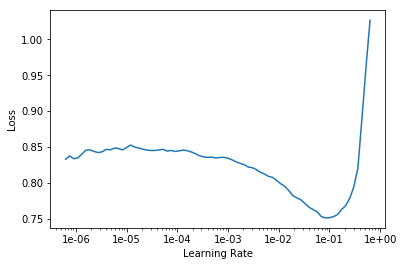

In [155]:
learning_rate()

In [137]:
lr = 5e-2
learn.fit_one_cycle(1,slice(lr))

Atelectasis     	 auc: 0.808	 chexpert auc: 0.858	 difference:    0.05
Cardiomegaly    	 auc: 0.752	 chexpert auc: 0.854	 difference:    0.102
Consolidation   	 auc: 0.89	 chexpert auc: 0.939	 difference:    0.0489
Edema           	 auc: 0.841	 chexpert auc: 0.941	 difference:    0.1
Pleural Effusion	 auc: 0.854	 chexpert auc: 0.936	 difference:    0.0825

Average auc: 0.829 	 CheXpert average auc 0.906	 Difference 0.0767


### Export entire model

In [140]:
if learn is None:
    learn = load_learner(data_path/'models','naive_densenet.pkl')
else:full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
    learn.export(data_path/'models'/'naive_densenet.pkl')

In [174]:
def get_preds_per_study():
    test_preds=learn.get_preds(ds_type=DatasetType.Test)[0]
   
    for i, c in enumerate(learn.data.classes):
        full_valid_df[c] = test_preds[:,i]
    
    return full_valid_df.groupby(['patient','study'])[learn.data.classes].max().reset_index()

In [175]:
get_preds_per_study()

,patient,study,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,patient64541,study1,0.293840,0.637843,0.227951,0.471375,0.564126
1,patient64542,study1,0.428389,0.752819,0.395615,0.462086,0.769751
2,patient64543,study1,0.408345,0.809447,0.209935,0.543768,0.685950
3,patient64544,study1,0.337066,0.571296,0.191840,0.415962,0.649121
4,patient64545,study1,0.131892,0.552577,0.260105,0.316173,0.729415
5,patient64546,study1,0.371507,0.645030,0.275401,0.551851,0.608237
6,patient64547,study1,0.413173,0.602957,0.253132,0.404910,0.733751
7,patient64548,study1,0.495279,0.547801,0.300953,0.406264,0.601967
8,patient64549,study1,0.411605,0.450619,0.173160,0.412159,0.405237
9,patient64550,study1,0.276679,0.652148,0.251639,0.363854,0.602401
